<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/ModellingPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A file to prep for Modelling

I start by loading the data, checking for duplicates and applying the preprocessing code provided by the dataset creator. This changes all images to grayscale and uniformises the size to 256 x 256.

In [2]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

import os  # Import os module for file operations
import hashlib

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = PROJECT_DIR / 'data' / 'raw' / data_type / label  # Use Path for joining
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = Path(root) / file  # Convert to Path object
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash: {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates: {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)

import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Number of duplicates: 0


Now try to fit a model. It uses `ImageDataGenerator` from `keras` to rescale the pixel values, do geometric transformations (rotations, flips, shears, zooms) of images and more. See: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

WRITING DOWN SOME SOURCES FOR DATA AUGMENTATION.

https://www.ibm.com/topics/data-augmentation 

https://www.datacamp.com/tutorial/complete-guide-data-augmentation
Image Augmentation

- Geometric transformations: randomly flip, crop, rotate, stretch, and zoom images. You need to be careful about applying multiple transformations on the same images, as this can reduce model performance. 
- Color space transformations: randomly change RGB color channels, contrast, and brightness.
- Kernel filters: randomly change the sharpness or blurring of the image. 
- Random erasing: delete some part of the initial image.
- Mixing images: blending and mixing multiple images. 

https://www.ibm.com/topics/data-augmentation

Wikipedia https://en.wikipedia.org/wiki/Data_augmentation

Data augmentation for image classification

When convolutional neural networks grew larger in mid-1990s, there was a lack of data to use, especially considering that some part of the overall dataset should be spared for later testing. It was proposed to perturb existing data with affine transformations to create new examples with the same labels,[6] which were complemented by so-called elastic distortions in 2003,[7] and the technique was widely used as of 2010s.[8] Data augmentation can enhance CNN performance and acts as a countermeasure against CNN profiling attacks.[9]

Data augmentation has become fundamental in image classification, enriching training dataset diversity to improve model generalization and performance. The evolution of this practice has introduced a broad spectrum of techniques, including geometric transformations, color space adjustments, and noise injection.[10]

Geometric Transformations

Geometric transformations alter the spatial properties of images to simulate different perspectives, orientations, and scales. Common techniques include:

- Rotation: Rotating images by a specified degree to help models recognize objects at various angles.
- Flipping: Reflecting images horizontally or vertically to introduce variability in orientation.
- Cropping: Removing sections of the image to focus on particular features or simulate closer views.
- Translation: Shifting images in different directions to teach models positional invariance.

Color Space Transformations

Color space transformations modify the color properties of images, addressing variations in lighting, color saturation, and contrast. Techniques include:

- Brightness Adjustment: Varying the image's brightness to simulate different lighting conditions.
- Contrast Adjustment: Changing the contrast to help models recognize objects under various clarity levels.
- Saturation Adjustment: Altering saturation to prepare models for images with diverse color intensities.
- Color Jittering: Randomly adjusting brightness, contrast, saturation, and hue to introduce color variability.
- Noise Injection: Injecting noise into images simulates real-world imperfections, teaching models to ignore irrelevant variations. Techniques involve:
- Gaussian Noise: Adding Gaussian noise mimics sensor noise or graininess.
- Salt and Pepper Noise: Introducing black or white pixels at random simulates sensor dust or dead pixels.


ChatGPT explanation of what `keras` is doing:

1. Rotation (rotation_range=40)

Purpose: Rotates images randomly within a range of ±40 degrees.
Benefit: Helps the model learn to recognize features regardless of their orientation. This is particularly useful in cases where the subject of the image might be positioned at different angles (e.g., brain scans that are slightly tilted).

2. Width Shift (width_shift_range=0.2)

Purpose: Randomly shifts images horizontally by up to 20% of the width of the image.
Benefit: Helps the model be less sensitive to the position of features along the horizontal axis. For example, if a brain tumor is off-center, this augmentation allows the model to still recognize it.

3. Height Shift (height_shift_range=0.2)

Purpose: Similar to width shifting, but vertically; shifts the image by up to 20% of the height.
Benefit: Makes the model more robust to vertical misalignments. This is beneficial when features aren’t perfectly centered.

4. Shear (shear_range=0.2)

Purpose: Applies a shearing transformation, which skews the image in a way that one side “slants” towards the other.
Benefit: Helps the model recognize objects that might be deformed or angled in an unusual way. This can simulate slight distortions that might occur in real-world imaging data.

5. Zoom (zoom_range=0.2)

Purpose: Randomly zooms into the image by up to 20%.
Benefit: Allows the model to learn from both close-up and wide-view perspectives of the features. This helps especially in medical images, where a feature could appear in different sizes.

6. Horizontal Flip (horizontal_flip=True)

Purpose: Flips the image horizontally with a 50% chance.
Benefit: This makes the model invariant to the left-right orientation of features. In cases where tumors or other key structures are equally likely to be on either side, this augmentation is helpful.

7. Fill Mode (fill_mode='nearest')

Purpose: Decides how to fill in pixels created by transformations like shifts and rotations.
Benefit: Using nearest ensures that new pixels introduced by transformations take the value of the nearest pixel, which can help preserve context and continuity at image edges.

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 98s 460ms/step - accuracy: 0.3999 - loss: 2.2416 - val_accuracy: 0.6727 - val_loss: 0.8567
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6562 - loss: 0.6993 - val_accuracy: 1.0000 - val_loss: 0.1396
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 137s 457ms/step - accuracy: 0.6909 - loss: 0.7734 - val_accuracy: 0.7305 - val_loss: 0.7265
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.6387 - val_accuracy: 0.9032 - val_loss: 0.2905
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 140s 448ms/step - accuracy: 0.7461 - loss: 0.6738 - val_accuracy: 0.6984 - val_loss: 0.9469
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.7500 - loss: 0.6382 - val_accuracy: 1.0000 - val_loss: 0.1790
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 86s 458ms/step - accuracy: 0.7430 - loss: 0.6482 - val_accuracy: 0.7305 - val_loss: 0.7386
Epoc

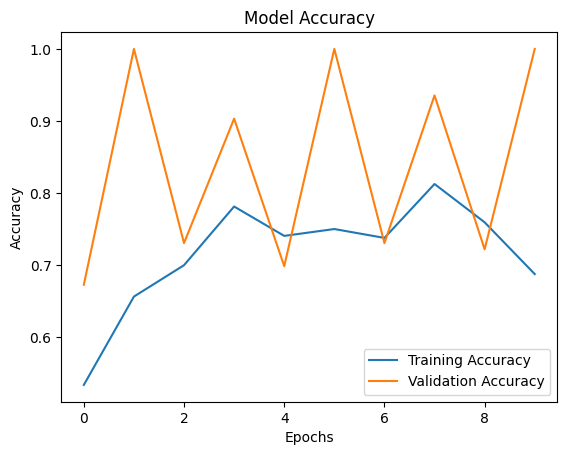

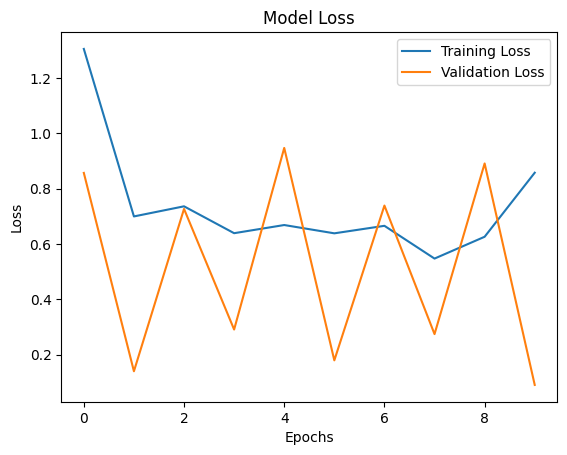

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
import matplotlib.pyplot as plt

# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Build the simplest CNN model
model = models.Sequential()

# Add just one convolutional layer followed by pooling
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten before the dense output layer
model.add(layers.Flatten())

# Output layer for multi-class classification
model.add(layers.Dense(len(LABELS), activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,  # Fewer epochs for faster training
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
